# **Install Dependencies**

In [ ]:
# optional: create an environment first
# python -m venv env-name
# env-name\Scripts\activate

! pip install ucimlrepo pandas seaborn
! pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo

# **Import and Explore Data**

In [ ]:
# fetch dataset
energy_efficiency = fetch_ucirepo(id=242)

# data (as pandas dataframes)
X = energy_efficiency.data.features
y = energy_efficiency.data.targets
dataset = pd.concat([X, y], axis=1)
dataset = dataset.drop(columns=['Y2']) # drop Y2 since we are only intereseted in Y1 (heating load)

print(dataset.head())


     X1     X2     X3      X4   X5  X6   X7  X8     Y1
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84


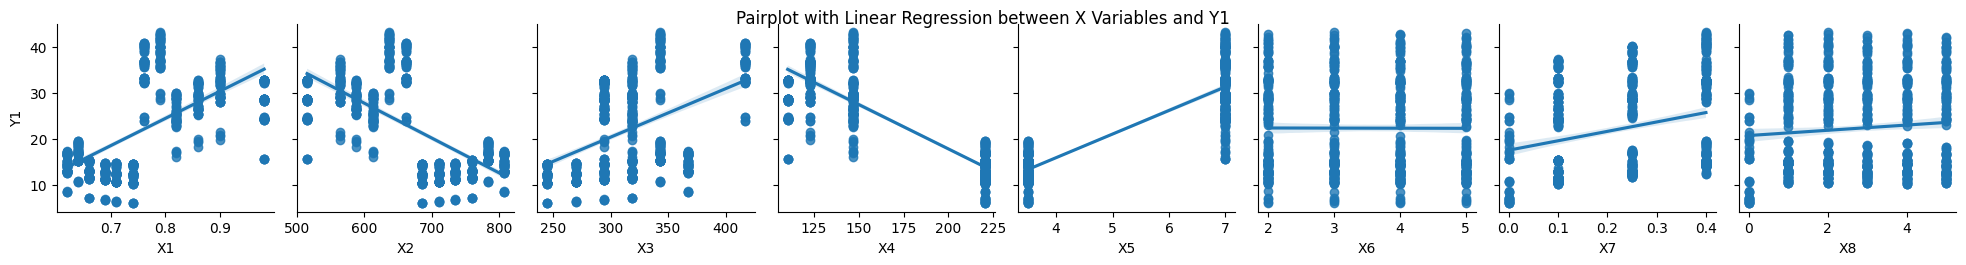

In [ ]:
# Visualize relationship of Y1 with all the features
sns.pairplot(dataset, y_vars=["Y1"], x_vars=dataset.columns[:-1], kind="reg")
plt.suptitle("Pairplot with Linear Regression between X Variables and Y1", y=1.02)
plt.show()

In [ ]:
# Check the Unique Values in each X Column
for i in dataset.columns[0:8]:
    print(i,'\nValues:', dataset[i].unique(),'\nTotal Number of valuesValues:', len(dataset[i].unique()),'\n')


X1 
Values: [0.98 0.9  0.86 0.82 0.79 0.76 0.74 0.71 0.69 0.66 0.64 0.62] 
Total Number of valuesValues: 12 

X2 
Values: [514.5 563.5 588.  612.5 637.  661.5 686.  710.5 735.  759.5 784.  808.5] 
Total Number of valuesValues: 12 

X3 
Values: [294.  318.5 343.  416.5 245.  269.5 367.5] 
Total Number of valuesValues: 7 

X4 
Values: [110.25 122.5  147.   220.5 ] 
Total Number of valuesValues: 4 

X5 
Values: [7.  3.5] 
Total Number of valuesValues: 2 

X6 
Values: [2 3 4 5] 
Total Number of valuesValues: 4 

X7 
Values: [0.   0.1  0.25 0.4 ] 
Total Number of valuesValues: 4 

X8 
Values: [0 1 2 3 4 5] 
Total Number of valuesValues: 6 



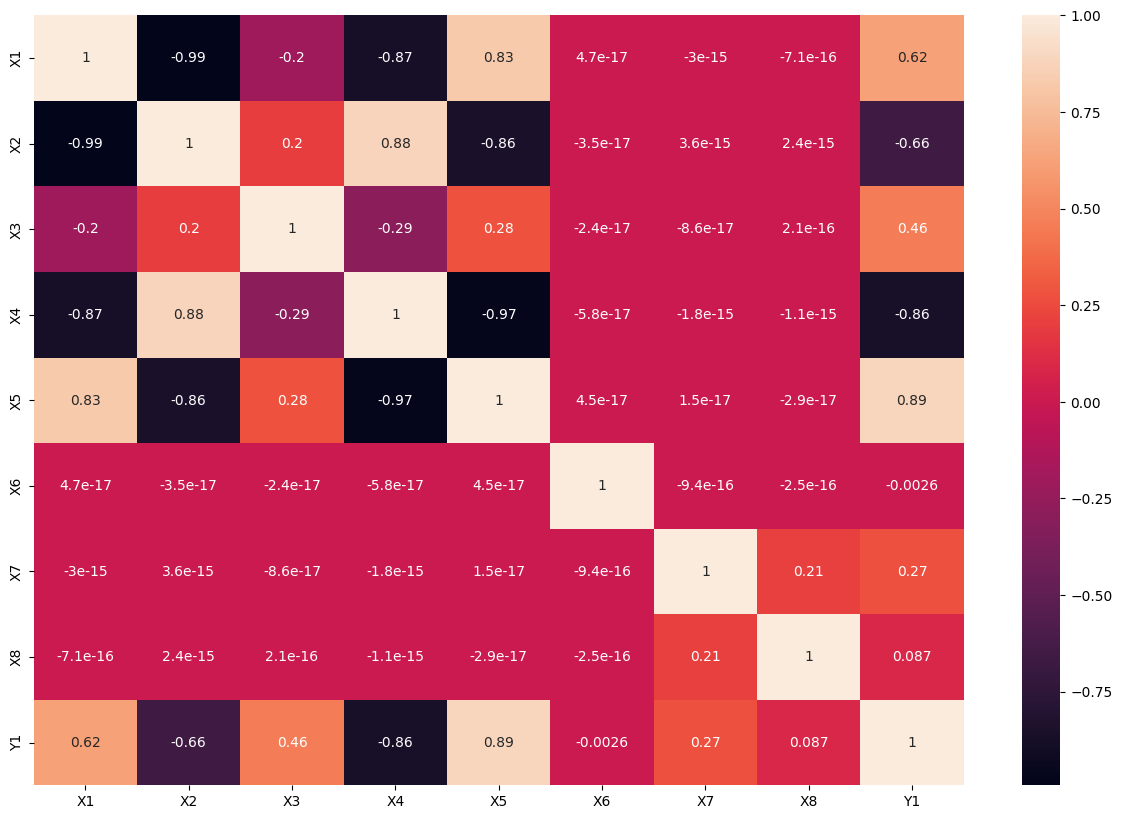

In [ ]:
# Since there a few unique values in each column, let's check if there is any significant correlation between each variables
# Plot the correlation of the dataset
correlation = dataset.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True)
plt.show()

In [ ]:
# Since the goal is to predict the heating load only, let's look for significant correlation with each X column
# Correlation focusing on Y1
correlation_matrix = dataset.corr()
print("Correlation matrix:\n", correlation_matrix[['Y1']])

Correlation matrix:
           Y1
X1  0.622272
X2 -0.658120
X3  0.455671
X4 -0.861828
X5  0.889431
X6 -0.002587
X7  0.269841
X8  0.087368
Y1  1.000000 



## **Split the Dataset**

In [ ]:
# Split dataset into 60% training and 40% for the validation and test
train_split, temp_data = train_test_split(dataset, test_size=0.4, random_state=42)

print("Training Split:")
print(train_split.head())

x_train = train_split.drop(columns=['Y1'])
y_train = train_split['Y1']

# Split the remaining 40% into 20% validation and 20% test
validation_split, test_split = train_test_split(temp_data, test_size=0.5, random_state=42)

print("\nValidation Split:")
print(validation_split.head())
print("\nTest Split:")
print(test_split.head())

x_validation = validation_split.drop(columns=['Y1'])
y_validation = validation_split['Y1']

x_test = test_split.drop(columns=['Y1'])
y_test = test_split['Y1']

Training Split:
       X1     X2     X3     X4   X5  X6    X7  X8     Y1
426  0.64  784.0  343.0  220.5  3.5   4  0.25   3  16.66
9    0.86  588.0  294.0  147.0  7.0   3  0.00   0  19.95
249  0.86  588.0  294.0  147.0  7.0   3  0.10   5  26.45
22   0.76  661.5  416.5  122.5  7.0   4  0.00   0  24.77
221  0.71  710.5  269.5  220.5  3.5   3  0.10   4  10.68

Validation Split:
       X1     X2     X3     X4   X5  X6    X7  X8     Y1
587  0.86  588.0  294.0  147.0  7.0   5  0.40   2  31.64
431  0.62  808.5  367.5  220.5  3.5   5  0.25   3  13.99
428  0.62  808.5  367.5  220.5  3.5   2  0.25   3  13.91
393  0.86  588.0  294.0  147.0  7.0   3  0.25   3  29.40
716  0.62  808.5  367.5  220.5  3.5   2  0.40   4  16.44

Test Split:
       X1     X2     X3     X4   X5  X6    X7  X8     Y1
381  0.62  808.5  367.5  220.5  3.5   3  0.25   2  14.66
148  0.90  563.5  318.5  122.5  7.0   2  0.10   3  28.07
494  0.82  612.5  318.5  147.0  7.0   4  0.25   5  24.60
754  0.69  735.0  294.0  220.5  3.5   4 

# **Linear Regression with Ridge Regularization**

In [ ]:
alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 0]

results = []

for alpha in alpha_values:
    #Build the model with Ridge regularization
    model_ridge = Ridge(alpha=alpha)

    #Train the model on the entire training set
    model_ridge.fit(x_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model_ridge.predict(x_validation)
    r2 = r2_score(y_validation, y_pred)

    # Store the results
    results.append({
        'alpha': alpha,
        'r2_score': r2,
        'prediction': y_pred,
        'actual': y_validation.values
    })

# Display the results
results_df = pd.DataFrame(results)
print("R2 Score Comparison of the Different Alpha Values on Validation Split:")
print(results_df[['alpha', 'r2_score']])

R2 Score Comparison of the Different Alpha Values on Validation Split:
    alpha  r2_score
0  0.0001  0.905021
1  0.0005  0.904994
2  0.0010  0.904961
3  0.0050  0.904691
4  0.0100  0.904359
5  0.0500  0.902380
6  0.1000  0.901093
7  0.5000  0.898913
8  1.0000  0.898230
9  0.0000  0.904990


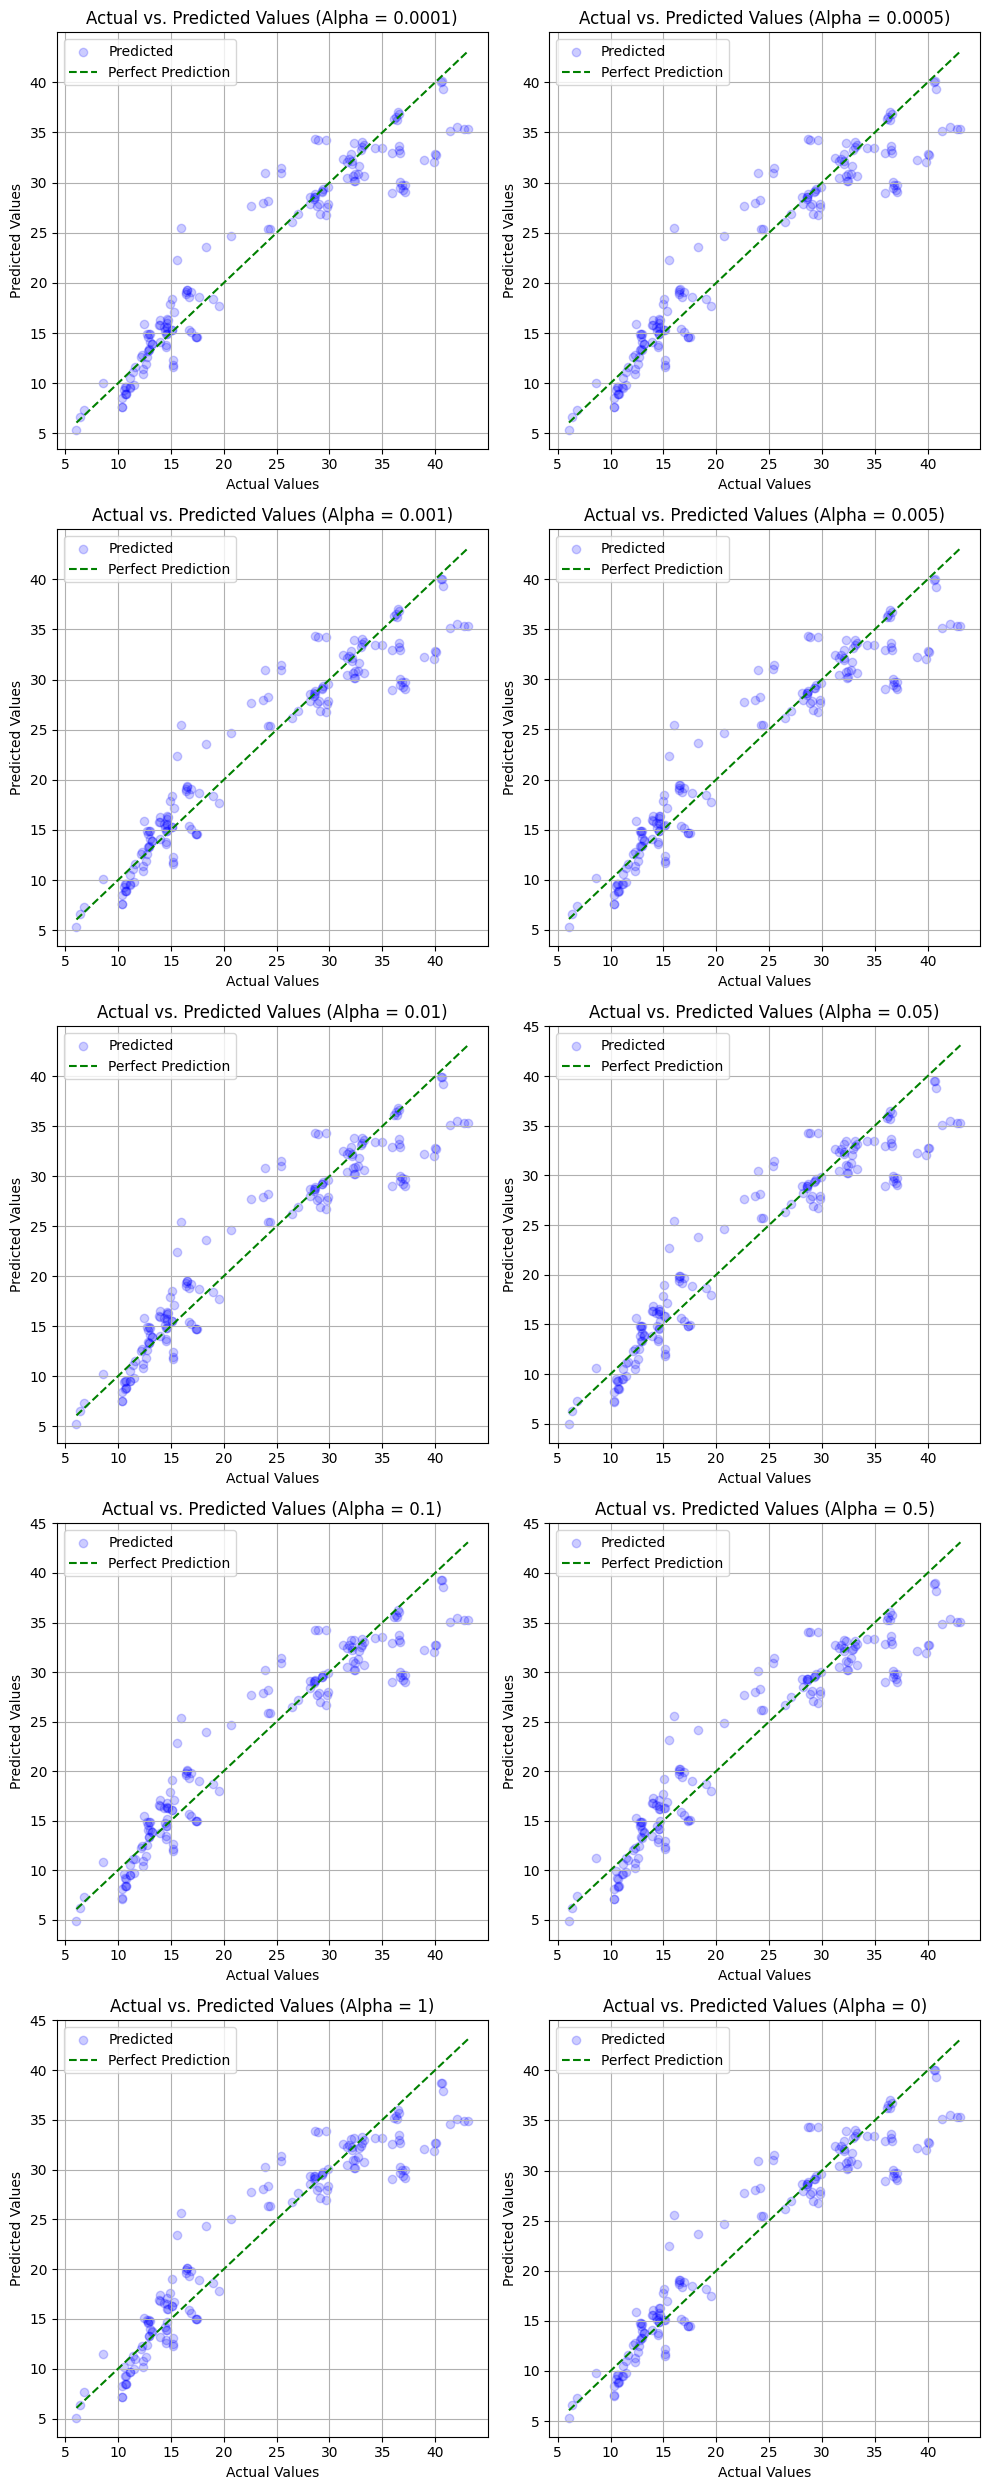

In [ ]:
#Create subplots for each alpha
fig, axs = plt.subplots(5, 2, figsize=(10, 25))
axs = axs.ravel()  # Flatten the array for easy indexing

# Plot each alpha's actual vs predicted values
for i, result in enumerate(results):
    axs[i].scatter(result['actual'], result['prediction'], color='blue', label='Predicted', alpha=0.2)
    axs[i].plot([min(result['actual']), max(result['actual'])],
                 [min(result['actual']), max(result['actual'])],
                 color='green', linestyle='--', label='Perfect Prediction')

    axs[i].set_title(f'Actual vs. Predicted Values (Alpha = {result["alpha"]})')
    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')
    axs[i].legend()
    axs[i].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Get the Coefficients of the Model with alpha value that has the highest R2 Score
alpha = 0.00011
best_ridge_model = make_pipeline(Ridge(alpha=alpha))
best_ridge_model.fit(x_train, y_train)
y_ridge_pred = best_ridge_model.predict(x_test)
r2 = r2_score(y_test, y_ridge_pred)

print("Performance Metrics for Ridge Regression Model:")
print(f"R^2: {r2:.4f}")

Performance Metrics for Ridge Regression Model:
R^2: 0.9196


In [ ]:
# Extract coefficients for Ridge Regression
ridge_coefficients = best_ridge_model.named_steps['ridge'].coef_
ridge_intercept = best_ridge_model.named_steps['ridge'].intercept_

print("Ridge Regression Model Coefficients:")
print(f"Intercept: {ridge_intercept}")
print(f"Coefficients: {ridge_coefficients}")

Ridge Regression Model Coefficients:
Intercept: 75.64037042737148
Coefficients: [-5.98298685e+01 -5.71589865e-02  3.68796625e-02 -4.70218808e-02
  4.16246410e+00 -1.80731621e-02  2.01603930e+01  2.44157586e-01]


In [ ]:
import pandas as pd
feature_names = X.columns
ridge_coefficients = best_ridge_model.named_steps['ridge'].coef_
ridge_intercept = best_ridge_model.named_steps['ridge'].intercept_

# Create a DataFrame to easily sort and select the top coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coefficients
})

# Sort by absolute value of coefficients and select top 5
top_5_coefficients = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index).head(5)

print("Ridge Regression Model Coefficients:")
print(f"Intercept: {ridge_intercept}")
print("Top 5 Coefficients by Absolute Value:\n", top_5_coefficients)

Ridge Regression Model Coefficients:
Intercept: 75.64037042737148
Top 5 Coefficients by Absolute Value:
   Feature  Coefficient
0      X1   -59.829868
6      X7    20.160393
4      X5     4.162464
7      X8     0.244158
1      X2    -0.057159
